In [1]:
import torch

from fashion_mnist_score.src.sde import VE_SDE, VP_SDE, SubVP_SDE
from fashion_mnist_score.src.unet import Unet

In [2]:
device = torch.device('cpu')

model = Unet(
    dim=28,
    dim_mults=(1, 2, 4),
    channels=1
).to(device)
model.load_state_dict(torch.load('fashion_mnist_score/ckpts/subvp.ckpt', map_location=torch.device('cpu')))

sde = SubVP_SDE(eps=1e-3, rescale=True).to(device)

/tmp/ipykernel_113893/29549652.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('fashion_mnist_score/ckpts/subvp.ckpt', map_location=torc

In [3]:
samples = sde.predictor_corrector_sample(model, (32, 1, 28, 28), device, n_lang_steps=2)
samples = torch.clamp(samples, 0, 1)

100%|█████████████████████████████████████████| 500/500 [04:05<00:00,  2.04it/s]


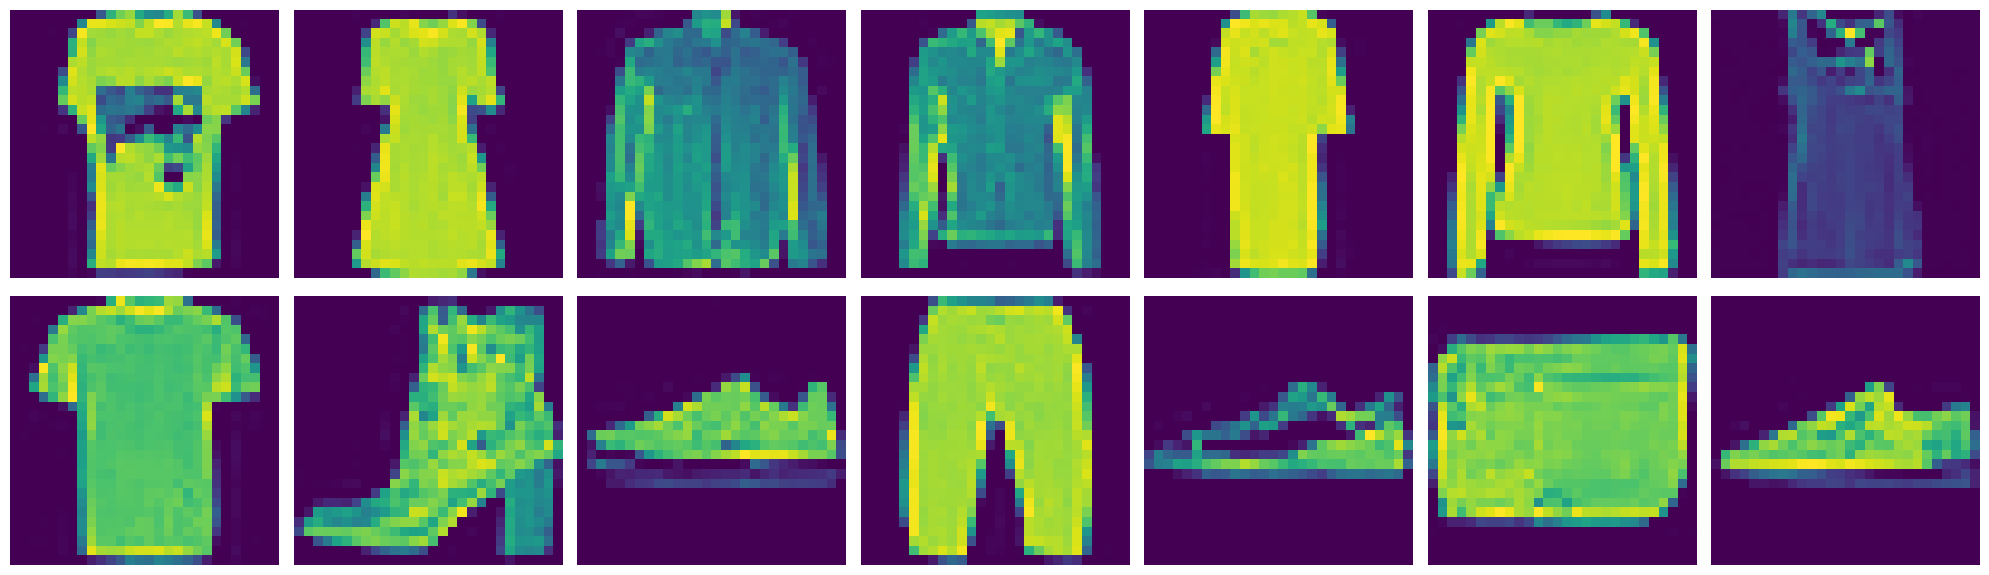

In [4]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

fig = plt.figure(figsize=(20, 6))
for i in range(1, 15):
    fig.add_subplot(2, 7, i)
    plt.axis('off')
    plt.imshow(to_pil_image(samples[i]))
    plt.tight_layout()
plt.savefig('samples.png')

In [58]:
z0, zT = samples[0].reshape(-1), samples[7].reshape(-1)

In [69]:
def init_curve_fun(z0, zT, T):
    
    lam = torch.linspace(0.0, 1.0, T+1).reshape(-1,1)[1:-1]
    theta = torch.arccos(torch.dot(z0,zT)/(torch.linalg.norm(z0)*torch.linalg.norm(zT)))
    
    return z0*torch.sin((1.-lam)*theta)/torch.sin(theta)+zT*torch.sin(lam*theta)/torch.sin(theta)
    

In [78]:
init_curve = init_curve_fun(z0,zT,100)

In [79]:
init_curve2 = torch.linspace(0.,1.,100+1)[1:-1].reshape(-1,1)*(zT.reshape(-1)-z0.reshape(-1))+z0.reshape(-1)

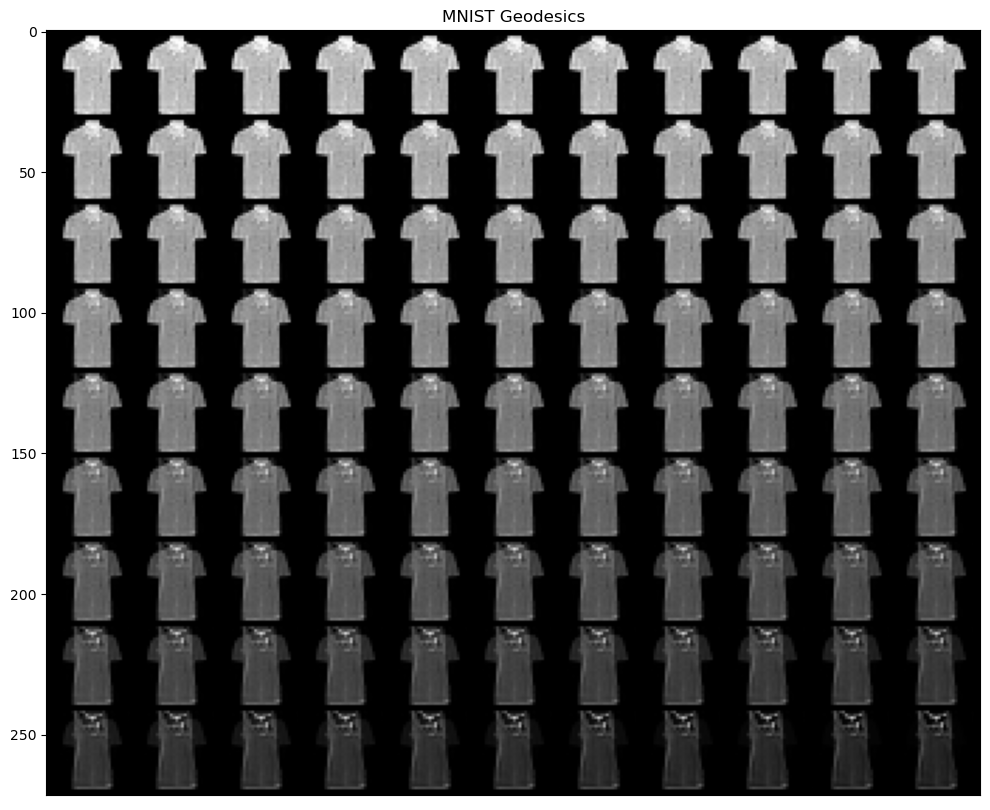

In [72]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

img_height = 28+2
tick_list = [img_height/2+j*img_height for j in range(10)]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"MNIST Geodesics")
ax.imshow(vutils.make_grid(init_curve.reshape(-1,1,28,28), padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)
#ax.set_yticks(tick_list)
#ax.set_yticklabels(length)

fig.tight_layout()

plt.show()


In [ ]:
#torch.save(z0, "z0.pt")
#torch.save(zT, "zT.pt")

In [64]:
torch.linalg.norm(test[0][1:-1]-init_curve)

tensor(0.1234)

In [3]:
z0 = torch.load("z0.pt")
zT = torch.load("zT.pt")

/tmp/ipykernel_72450/1452057480.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z0 = torch.load("z0.pt")
/tmp/ipykernel_72450/1452057480.py:2: FutureWarning: You are usi

In [17]:
import torch

from torch_geometry.riemannian.prob_geodesics import ProbGEORCE, ProbEuclideanGEORCE
from torch_geometry.riemannian.prob_geodesics import ProbSGEORCE, ProbEuclideanSGEORCE
from torch_geometry.riemannian.prob_geodesics import ProbAdaGEORCE, ProbEuclideanAdaGEORCE
from torch_geometry.riemannian.prob_geodesics import TorchOptimization, TorchEuclideanOptimization
from torch_geometry.riemannian.manifolds import nSphere

In [18]:
def score_fun(x,t):
    
    x = x.reshape(-1,1,28,28)
    
    score = model(x, t*torch.ones(len(x)))
                   
    return score.reshape(-1)
    

In [85]:
t0 = 0.01
M_ProbGEORCE = ProbEuclideanGEORCE(score_fun = lambda z: score_fun(z,t0),#lambda z: score_fun(z,t0),
                                    init_fun=init_curve_fun,#lambda *args: init_val,#None,
                                    lam=10.0,#,t0**4,
                                    T=100,
                                    max_iter=100,
                                    line_search_params={'rho': 0.1, 'max_iter': 100},
                                   )

In [38]:
t0 = 0.01
M_ProbAdaGEORCE = ProbEuclideanAdaGEORCE(score_fun = lambda z: score_fun(z,t0),#lambda z: score_fun(z,t0),
                                    init_fun=None,#lambda *args: init_val,#None,
                                    lam=10.0,#,t0**4,
                                    T=100,
                                    max_iter=1000,
                                      lr_rate=0.0001,
                                      beta1 = 0.5,
                                      beta2 = 0.5,
                                   )

In [42]:
t0 = 0.01
M_ProbTorch = TorchEuclideanOptimization(score_fun = lambda z: score_fun(z,t0),#lambda z: score_fun(z,t0),
                                        init_fun=None,#lambda *args: init_val,#None,
                                         lr_rate=0.01,
                                        lam=100.0,#,t0**4,
                                        T=100,
                                        max_iter=1000,
                                       )

In [86]:
#beta1=0.0,beta2=0.0,lr_rate=0.001, loss = 24.45 (after 1000 iterations)
#beta1=0.5,beta2=0.5,lr_rate=0.001, loss =  (after 1000 iterations)

test = M_ProbGEORCE(z0,zT)

18.515274047851562
0
15.008642196655273
1
12.693946838378906
2
11.100043296813965
3
10.055756568908691
4
9.383288383483887
5
8.943626403808594
6
8.533970832824707
7
7.9841108322143555
8
7.674375057220459
9
7.491111755371094
10
7.363317489624023
11
7.10097599029541
12
6.951410293579102
13
6.86004114151001
14
6.7241621017456055
15
6.590588092803955
16
6.513418197631836
17
6.452548503875732
18
6.331214427947998
19
6.263089179992676
20
6.248712539672852
21
6.133335113525391
22
6.070932865142822
23
6.0340118408203125
24
5.976629257202148
25
5.918321132659912
26
5.884739875793457
27
5.848703384399414
28
5.79262638092041
29
5.761308670043945
30
5.741037368774414
31
5.686662197113037
32
5.656931400299072
33
5.649266242980957
34
5.595338821411133
35
5.566605091094971
36
5.549559593200684
37
5.51542854309082
38
5.487390041351318
39
5.471125602722168
40
5.444785118103027
41
5.41694450378418
42
5.401206016540527
43
5.381516456604004
44
5.353715419769287
45
5.338324546813965
46
5.324640274047852
47

In [39]:
#beta1=0.0,beta2=0.0,lr_rate=0.001, loss = 24.45 (after 1000 iterations)
#beta1=0.5,beta2=0.5,lr_rate=0.001, loss =  (after 1000 iterations)

test3 = M_ProbAdaGEORCE(z0,zT)

10.096566200256348
0
36.58908462524414
1
37.410240173339844
2
36.6138801574707
3
33.516170501708984
4
27.317686080932617
5
20.81654167175293
6
17.31036376953125
7
15.799880027770996
8
15.081658363342285
9
14.651020050048828
10
14.334019660949707
11
14.070249557495117
12
13.837423324584961
13
13.62629508972168
14
13.432048797607422
15
13.25151252746582
16
13.082338333129883
17
12.922746658325195
18
12.77133560180664
19
12.627020835876465
20
12.489069938659668
21
12.357064247131348
22
12.230733871459961
23
12.109780311584473
24
11.993829727172852
25
11.882468223571777
26
11.775357246398926
27
11.672343254089355
28
11.573549270629883
29
11.479406356811523
30
11.390630722045898
31
11.308043479919434
32
11.232290267944336
33
11.163454055786133
34
11.100896835327148
35
11.043439865112305
36
10.989823341369629
37
10.939085960388184
38
10.890679359436035
39
10.844342231750488
40
10.79995346069336
41
10.757413864135742
42
10.716615676879883
43
10.677441596984863
44
10.639775276184082
45
10.6035

7.47318696975708
377
7.469042778015137
378
7.464920997619629
379
7.460820198059082
380
7.456743240356445
381
7.452690124511719
382
7.448661804199219
383
7.444658279418945
384
7.440680027008057
385
7.436726093292236
386
7.432798862457275
387
7.428894996643066
388
7.425016403198242
389
7.4211602210998535
390
7.417328834533691
391
7.413519382476807
392
7.409730911254883
393
7.405963897705078
394
7.402216911315918
395
7.398489952087402
396
7.394780158996582
397
7.391087532043457
398
7.38741397857666
399
7.383755207061768
400
7.3801116943359375
401
7.376483917236328
402
7.372870445251465
403
7.369270324707031
404
7.365683555603027
405
7.362109184265137
406
7.358547687530518
407
7.354997634887695
408
7.35145902633667
409
7.347931861877441
410
7.344414234161377
411
7.340906143188477
412
7.337409019470215
413
7.333921909332275
414
7.330443382263184
415
7.326974868774414
416
7.323514461517334
417
7.320062637329102
418
7.316619396209717
419
7.3131842613220215
420
7.309757232666016
421
7.30633735

6.459144592285156
750
6.457111835479736
751
6.455082416534424
752
6.453055381774902
753
6.4510297775268555
754
6.449007987976074
755
6.446988105773926
756
6.44497013092041
757
6.442954063415527
758
6.44094181060791
759
6.438932418823242
760
6.436923980712891
761
6.4349188804626465
762
6.432916641235352
763
6.430916786193848
764
6.428919792175293
765
6.426925182342529
766
6.424933433532715
767
6.422944068908691
768
6.420957088470459
769
6.418973922729492
770
6.4169921875
771
6.415013313293457
772
6.413038730621338
773
6.411065101623535
774
6.409095287322998
775
6.407127857208252
776
6.405163764953613
777
6.403203010559082
778
6.401244163513184
779
6.399288654327393
780
6.397336483001709
781
6.395386219024658
782
6.393439769744873
783
6.391495704650879
784
6.389554977416992
785
6.387618064880371
786
6.385684013366699
787
6.383752346038818
788
6.381823539733887
789
6.379899024963379
790
6.377976417541504
791
6.376057147979736
792
6.374140739440918
793
6.372228145599365
794
6.3703184127807

In [21]:
test[-2]

32.005516052246094

In [24]:
torch.linalg.norm(test[0][1:-1]-init_curve)

tensor(0.1853)

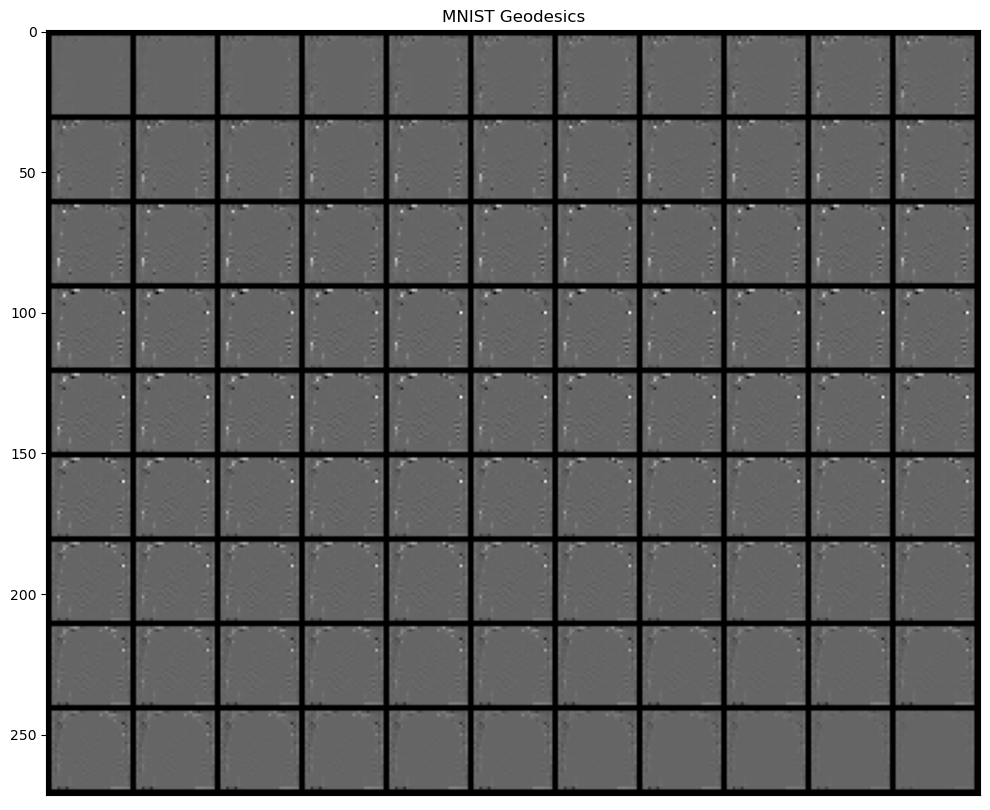

In [26]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

img_height = 28+2
tick_list = [img_height/2+j*img_height for j in range(10)]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"MNIST Geodesics")
ax.imshow(vutils.make_grid((test[0][1:-1]-init_curve).reshape(-1,1,28,28), padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)
#ax.set_yticks(tick_list)
#ax.set_yticklabels(length)

fig.tight_layout()

plt.show()


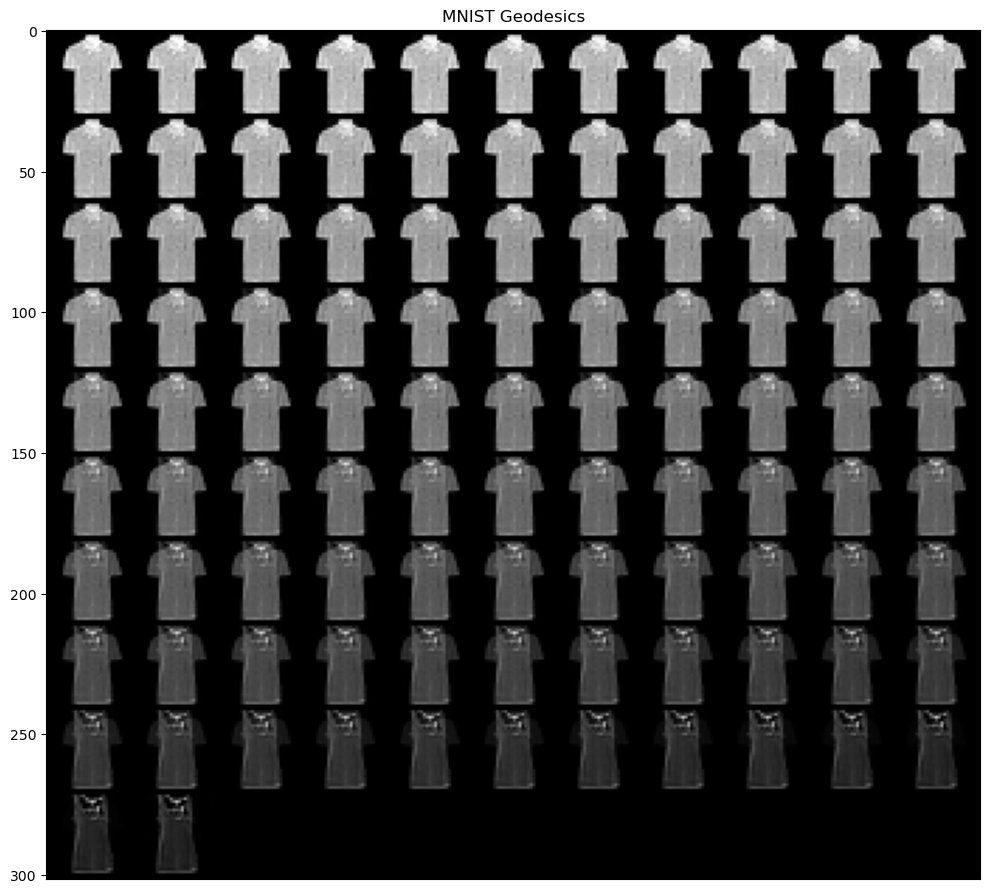

In [87]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

img_height = 28+2
tick_list = [img_height/2+j*img_height for j in range(10)]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"MNIST Geodesics")
ax.imshow(vutils.make_grid(test[0].reshape(-1,1,28,28), padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)
#ax.set_yticks(tick_list)
#ax.set_yticklabels(length)

fig.tight_layout()

plt.show()


In [ ]:
test[0].shape

In [43]:
test2 = M_ProbTorch(z0,zT)

0
92.704833984375
1
162.39805603027344
2
86.33613586425781
3
78.28150177001953
4
76.7781753540039
5
75.58143615722656
6
74.65363311767578
7
74.14046478271484
8
73.82060241699219
9
73.37627410888672
10
72.74732971191406
11
72.0526123046875
12
71.3896713256836
13
70.74168395996094
14
70.01727294921875
15
69.2522964477539
16
68.4408950805664
17
67.59603118896484
18
66.66947174072266
19
65.69619750976562
20
64.7463607788086
21
63.733558654785156
22
62.652313232421875
23
61.620479583740234
24
60.58177947998047
25
59.496185302734375
26
58.386417388916016
27
57.2635612487793
28
56.13764572143555
29
54.991416931152344
30
53.84379196166992
31
52.71649932861328
32
51.59492111206055
33
50.48676300048828
34
49.38606262207031
35
48.30194091796875
36
47.155250549316406
37
46.0467643737793
38
44.98558044433594
39
43.9069709777832
40
42.81022644042969
41
41.736202239990234
42
40.61595916748047
43
39.624263763427734
44
38.61843490600586
45
37.615028381347656
46
36.5908317565918
47
35.643653869628906
48

376
6.187932968139648
377
6.277318954467773
378
6.257699966430664
379
6.257313251495361
380
6.375247001647949
381
6.400014877319336
382
6.756746292114258
383
6.595685958862305
384
6.514540672302246
385
6.665667533874512
386
6.494294166564941
387
6.4741315841674805
388
6.892752170562744
389
6.524597644805908
390
6.953721046447754
391
6.81587553024292
392
6.772156715393066
393
6.7452545166015625
394
6.538538932800293
395
6.698163032531738
396
6.592555999755859
397
6.812030792236328
398
6.6289777755737305
399
6.711902618408203
400
6.684328079223633
401
6.574075698852539
402
6.458556175231934
403
6.525014877319336
404
6.435565948486328
405
6.4015069007873535
406
6.269609451293945
407
6.302203178405762
408
6.341501235961914
409
6.326911926269531
410
6.239264488220215
411
6.158785820007324
412
6.0801544189453125
413
6.019075393676758
414
6.0834150314331055
415
6.059120178222656
416
6.0924072265625
417
6.024794578552246
418
6.044156074523926
419
6.043699264526367
420
5.972236633300781
421
5.9

749
5.177770614624023
750
5.24469518661499
751
5.191553592681885
752
5.2425994873046875
753
5.213600158691406
754
5.163164138793945
755
5.161821365356445
756
5.132877349853516
757
5.230955600738525
758
5.172738552093506
759
5.126850128173828
760
5.131380081176758
761
5.098574638366699
762
5.073988914489746
763
5.0424699783325195
764
5.06873083114624
765
5.045449256896973
766
5.070636749267578
767
5.101990699768066
768
5.050724983215332
769
5.090224266052246
770
5.12919807434082
771
5.087361812591553
772
5.05449104309082
773
5.060434341430664
774
5.037746429443359
775
5.054588317871094
776
5.043734073638916
777
5.012551307678223
778
4.95722770690918
779
4.936481475830078
780
4.938183784484863
781
4.959110260009766
782
4.989938735961914
783
4.928735733032227
784
4.941656112670898
785
4.945995807647705
786
4.933945178985596
787
4.964503765106201
788
4.953174591064453
789
4.979666233062744
790
4.94025182723999
791
4.936436653137207
792
4.91122579574585
793
4.870667934417725
794
4.801038742

In [29]:
test2[0].shape

torch.Size([101, 784])

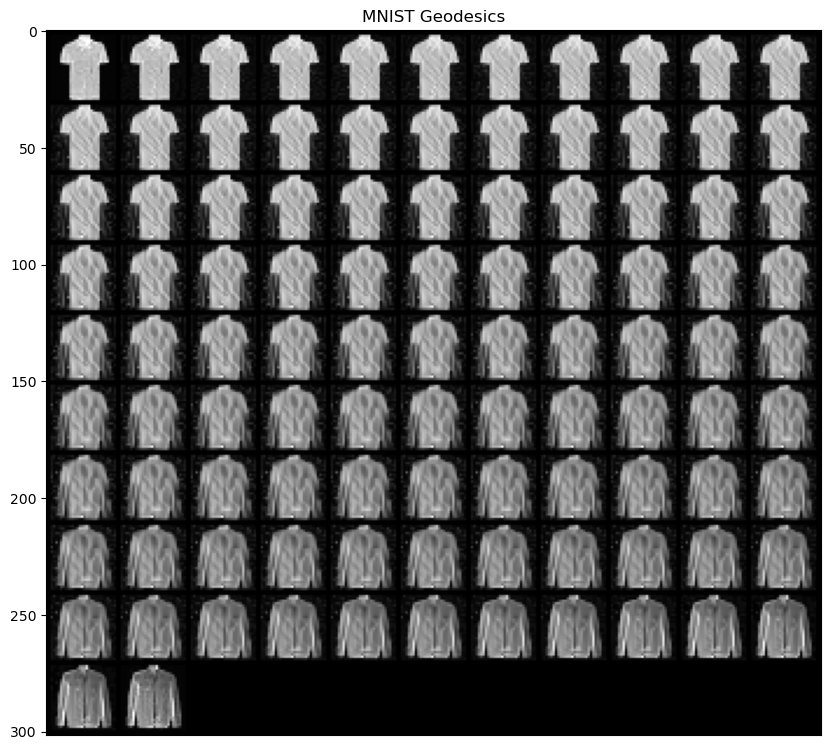

In [48]:
img_height = 28+2
tick_list = [img_height/2+j*img_height for j in range(10)]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"MNIST Geodesics")
ax.imshow(vutils.make_grid(test2[0].reshape(-1,1,28,28), padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)
#ax.set_yticks(tick_list)
#ax.set_yticklabels(length)

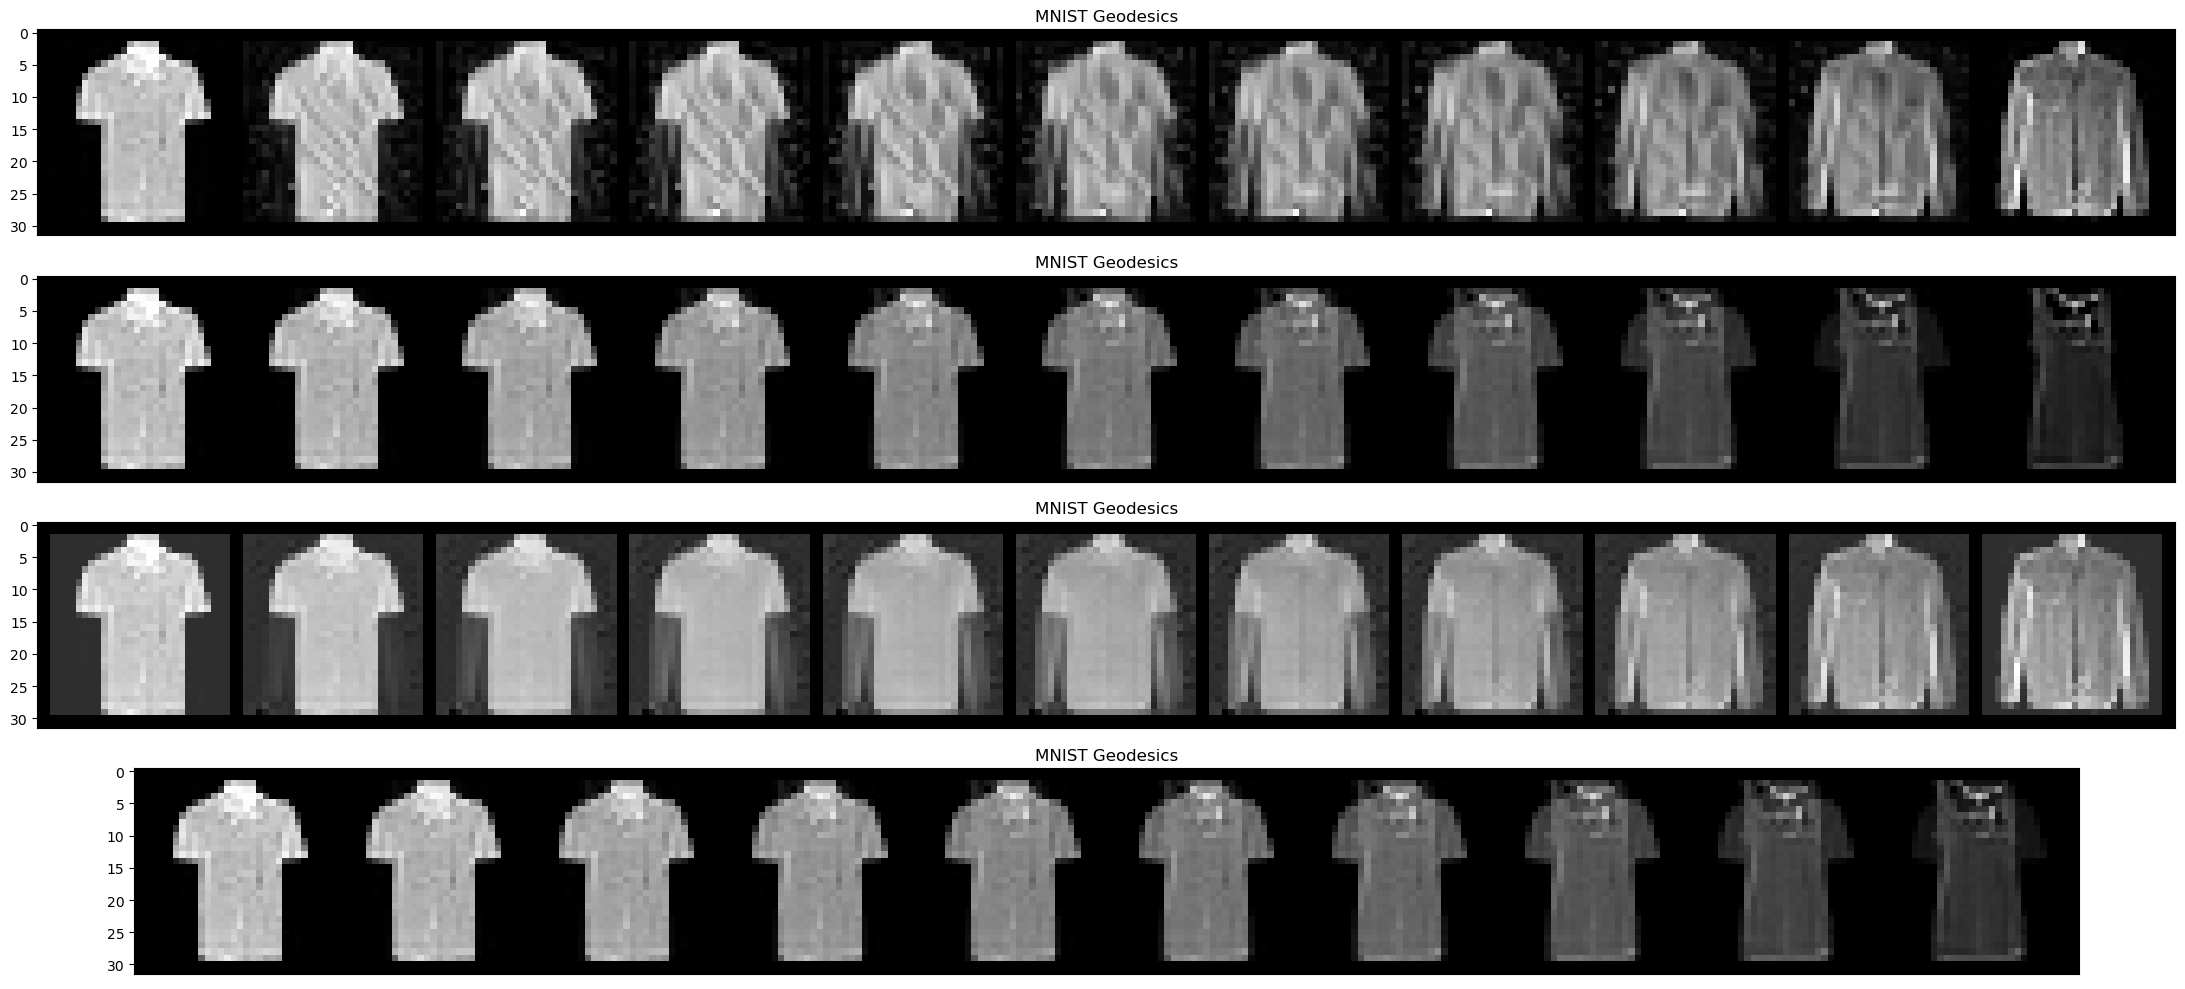

In [88]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

img_height = 28+2
tick_list = [img_height/2+j*img_height for j in range(10)]
fig = plt.figure(figsize=(40,10))
ax = fig.add_subplot(411)
ax.set_title(f"MNIST Geodesics")
ax.imshow(vutils.make_grid(test2[0].reshape(-1,1,28,28)[::10], padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)
#ax.set_yticks(tick_list)
#ax.set_yticklabels(length)

ax = fig.add_subplot(412)
ax.set_title(f"MNIST Geodesics")
ax.imshow(vutils.make_grid(test[0].reshape(-1,1,28,28)[::10], padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)

ax = fig.add_subplot(413)
ax.set_title(f"MNIST Geodesics")
ax.imshow(vutils.make_grid(test3[0].reshape(-1,1,28,28)[::10], padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)

ax = fig.add_subplot(414)
ax.set_title(f"MNIST Geodesics")
ax.imshow(vutils.make_grid(init_curve.reshape(-1,1,28,28)[::10], padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)

fig.tight_layout()

plt.show()


In [ ]:
t0 = 0.01
M_ProbGEORCE = ProbEuclideanGEORCE(score_fun = lambda z: score_fun(z,t0),#lambda z: score_fun(z,t0),
                                    init_fun=lambda *args: test2[0][1:-1],#lambda *args: init_val,#None,
                                    lam=50.0,#,t0**4,
                                    T=100,
                                    max_iter=100,
                                    line_search_params={'rho': 0.1, 'max_iter': 100},
                                   )

In [ ]:
test3 = M_ProbGEORCE(z0, zT, lam = M_ProbTorch.lam_norm)

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

img_height = 28+2
tick_list = [img_height/2+j*img_height for j in range(10)]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"MNIST Geodesics")
ax.imshow(vutils.make_grid(test3[0].reshape(-1,1,28,28)[::10], padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)
#ax.set_yticks(tick_list)
#ax.set_yticklabels(length)

fig.tight_layout()

plt.show()


In [36]:
init_curve = torch.vstack((z0,
                           torch.linspace(0.,1.,100+1)[1:-1].reshape(-1,1)*(zT.reshape(-1)-z0.reshape(-1))+z0.reshape(-1),
                           zT))

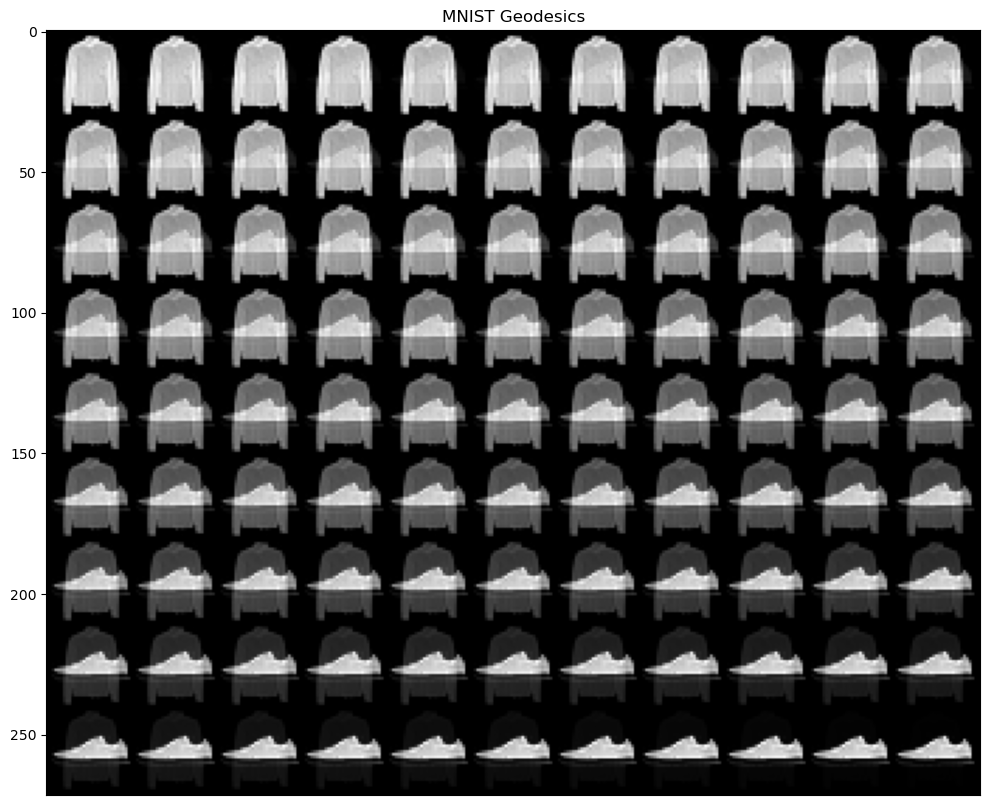

In [72]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

img_height = 28+2
tick_list = [img_height/2+j*img_height for j in range(10)]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"MNIST Geodesics")
ax.imshow(vutils.make_grid(init_curve.reshape(-1,1,28,28), padding=2, normalize=True, nrow=10+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)
#ax.set_yticks(tick_list)
#ax.set_yticklabels(length)

fig.tight_layout()

plt.show()
